# **Hotel Cancellation Prediction**



**1. Import**

In [1]:
import pandas as pd
import numpy as np

**2. Dataset**

In [2]:
data = pd.read_csv('booking.csv')

data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


**3. Drop Useless Data**

In [3]:
data.drop(['Booking_ID', 'P-not-C'], axis=1, inplace=True)


**4. Set X & Y**

In [4]:
# Convert 'date of reservation' to datetime
data['date of reservation'] = pd.to_datetime(data['date of reservation'],errors='coerce')

# Create new features based on 'date of reservation'
data['reservation_year'] = data['date of reservation'].dt.year
data['reservation_month'] = data['date of reservation'].dt.month
data['reservation_day'] = data['date of reservation'].dt.day
data['reservation_dayofweek'] = data['date of reservation'].dt.dayofweek

# Drop the original 'date of reservation' column
data = data.drop(['date of reservation'], axis=1)

data.dropna(subset=['reservation_year', 'reservation_month', 'reservation_day', 'reservation_dayofweek'], inplace=True)

# Create dummy variables and set X & Y
X = data.drop(['booking status'], axis=1)
y = data['booking status']
X = pd.get_dummies(X)

**5. Train, Validation and Test Split**

In [5]:
from sklearn.model_selection import train_test_split

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.1, random_state=42)

print(X_train.shape[0])
print(len(y_train))

29360
29360


**6. Standardize 'Average Price'**

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
s = StandardScaler()

# Standardize the 'average price' column on the training set
s.fit(X_train[['average price']])

# Transform the 'average price' column on the training and validation sets
x_train_std = s.transform(X_train[['average price']])
x_valid_std = s.transform(X_valid[['average price']])

# Create DataFrames from standardized data
x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_valid_std = pd.DataFrame(x_valid_std, columns=['average price'])

# Drop the 'average price' column from x_train_std and x_valid_std
X_train = X_train.drop(columns=['average price'])
X_valid = X_valid.drop(columns=['average price'])

# Reset the index of DataFrames before concatenation
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_valid_std.reset_index(drop=True, inplace=True)

# Concatenate standardized data with the rest of the data
X_train = pd.concat([x_train_std, X_train], axis=1)
X_valid = pd.concat([x_valid_std, X_valid], axis=1)

# Print the first few rows of concatenated DataFrames
print(X_train.head())
print(X_valid.head())


   average price  number of adults  number of children  \
0      -0.805801                 2                   0   
1      -0.200849                 2                   0   
2      -1.033012                 1                   0   
3      -0.712076                 2                   0   
4      -0.386879                 2                   0   

   number of weekend nights  number of week nights  car parking space  \
0                         0                      3                  0   
1                         1                      1                  0   
2                         2                      0                  1   
3                         2                      0                  0   
4                         1                      2                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0        146         0    0                 0  ...                  False   
1         57         0    0                 0  ...        

**7. K-Nearest Neighbors**

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ('hamming', 'euclidean', 'manhattan')}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with the KNN classifier and parameters
grid_search = GridSearchCV(knn, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search.fit(X_train, y_train)

# Best model and best parameters
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model:", best_knn_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .....metric=hamming, n_neighbors=3;, score=0.809 total time=   2.5s
[CV 2/5] END .....metric=hamming, n_neighbors=3;, score=0.814 total time=   2.8s
[CV 3/5] END .....metric=hamming, n_neighbors=3;, score=0.815 total time=   2.4s
[CV 4/5] END .....metric=hamming, n_neighbors=3;, score=0.817 total time=   2.5s
[CV 5/5] END .....metric=hamming, n_neighbors=3;, score=0.808 total time=   2.4s
[CV 1/5] END .....metric=hamming, n_neighbors=5;, score=0.814 total time=   3.1s
[CV 2/5] END .....metric=hamming, n_neighbors=5;, score=0.816 total time=   3.7s
[CV 3/5] END .....metric=hamming, n_neighbors=5;, score=0.812 total time=   3.2s
[CV 4/5] END .....metric=hamming, n_neighbors=5;, score=0.821 total time=   3.1s
[CV 5/5] END .....metric=hamming, n_neighbors=5;, score=0.811 total time=   3.5s
[CV 1/5] END .....metric=hamming, n_neighbors=7;, score=0.817 total time=   3.5s
[CV 2/5] END .....metric=hamming, n_neighbors=7;

**8. Support Vector Machines**

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale']}

# Initialize the SVM classifier
svm_classifier = SVC()

# Initialize GridSearchCV with the SVM classifier and parameters
grid_search_svm = GridSearchCV(svm_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Fit GridSearchCV on the data
grid_search_svm.fit(X_train, y_train)

# Best model and best parameters
best_svm_model = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Best SVM model:", best_svm_model)
print("Best SVM parameters:", best_params_svm)
print("Best SVM score:", best_score_svm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.798 total time=  19.9s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.804 total time=  17.1s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.800 total time=  16.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=  16.3s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.789 total time=  16.9s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.739 total time=  34.4s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.744 total time=  33.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.747 total time=  30.5s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.743 total time=  31.6s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.742 total time=  31.6s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.742 total time=  20.6s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;,

**9. Linear Discriminant Analysis**

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV

# Define a list of parameters to explore
parameters = {'solver': ['lsqr'],
              'shrinkage': ['auto', None],
              'n_components': [None, 1]}

# Initialize the LDA model
lda = LDA()

# Initialize GridSearchCV with the LDA model and parameters
grid_search_lda = GridSearchCV(lda, parameters, cv=5, scoring='accuracy')

# Fit GridSearchCV on the data
grid_search_lda.fit(X_train, y_train)

# Best model and best parameters
best_lda_model = grid_search_lda.best_estimator_
best_params = grid_search_lda.best_params_
best_score = grid_search_lda.best_score_

print("Best model:", best_lda_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Najbolji model: LinearDiscriminantAnalysis(solver='lsqr')
Najbolji parametri: {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}
Najbolji rezultat: 0.7983310626702996


**10. Test Best Solutions**

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
s = StandardScaler()

# Standardize the 'average price' column on the training set
s.fit(X_train1[['average price']])

# Transform the 'average price' column on the training and validation sets
x_train_std = s.transform(X_train1[['average price']])
x_test_std = s.transform(X_test[['average price']])

# Create DataFrames from standardized data
x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_test_std = pd.DataFrame(x_test_std, columns=['average price'])

# Drop the 'average price' column from x_train_std and x_test_std
X_train1 = X_train1.drop(columns=['average price'])
X_test = X_test.drop(columns=['average price'])

# Reset the index of DataFrames before concatenation
X_train1.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_test_std.reset_index(drop=True, inplace=True)

# Concatenate standardized data with the rest of the data
X_train1 = pd.concat([x_train_std, X_train1], axis=1)
X_test = pd.concat([x_test_std, X_test], axis=1)

# Print the first few rows of concatenated DataFrames
print(X_train1.head())
print(X_test.head())

   average price  number of adults  number of children  \
0      -0.040411                 2                   0   
1      -0.612680                 2                   0   
2      -0.752189                 1                   0   
3       0.585953                 2                   0   
4       0.158887                 2                   0   

   number of weekend nights  number of week nights  car parking space  \
0                         2                      2                  0   
1                         0                      1                  0   
2                         1                      1                  0   
3                         0                      3                  0   
4                         2                      1                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0          4         0    0                 1  ...                  False   
1         30         0    0                 0  ...        

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with the best parameters
best_knn_model = KNeighborsClassifier(n_neighbors=11, metric='hamming')

# Train the final KNN model on the training data
best_knn_model.fit(X_train1, y_train1)

# Evaluate the performance of the final KNN model on the test data
knn_accuracy = best_knn_model.score(X_test, y_test)
print("Accuracy of the final KNN model:", knn_accuracy)

Tačnost finalnog KNN modela: 0.8173793103448276


In [12]:
from sklearn.svm import SVC

# Initialize the SVM classifier with the best parameters
best_svm_model = SVC(C=0.1, kernel='linear', gamma='scale')

# Train the final SVM model on the training data
best_svm_model.fit(X_train1, y_train1)

# Evaluate the performance of the final SVM model on the test data
svm_accuracy = best_svm_model.score(X_test, y_test)
print("Accuracy of the final SVM model:", svm_accuracy)

Tačnost finalnog SVM modela: 0.791448275862069


In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Initialize the LDA classifier with the best parameters
best_lda_model = LDA(solver='lsqr')

# Train the final LDA model on the training data
best_lda_model.fit(X_train1, y_train1)

# Evaluate the performance of the final LDA model on the test data
lda_accuracy = best_lda_model.score(X_test, y_test)
print("Accuracy of the final LDA model:", lda_accuracy)

Tačnost finalnog logističkog modela: 0.791448275862069


In [14]:
# Evaluation of the best KNN model on the test set
knn_test_score = best_knn_model.score(X_test, y_test)
print("Accuracy of the KNN model on the test set:", knn_test_score)

# Evaluation of the best SVM model on the test set
svm_test_score = best_svm_model.score(X_test, y_test)
print("Accuracy of the SVM model on the test set:", svm_test_score)

# Evaluation of the best LDA model on the test set
lda_test_score = best_lda_model.score(X_test, y_test)
print("Accuracy of the LDA model on the test set:", lda_test_score)

Tacnost modela KNN na test skupu: 0.8173793103448276
Tacnost modela SVM na test skupu: 0.791448275862069
Tacnost modela LDA na test skupu: 0.791448275862069


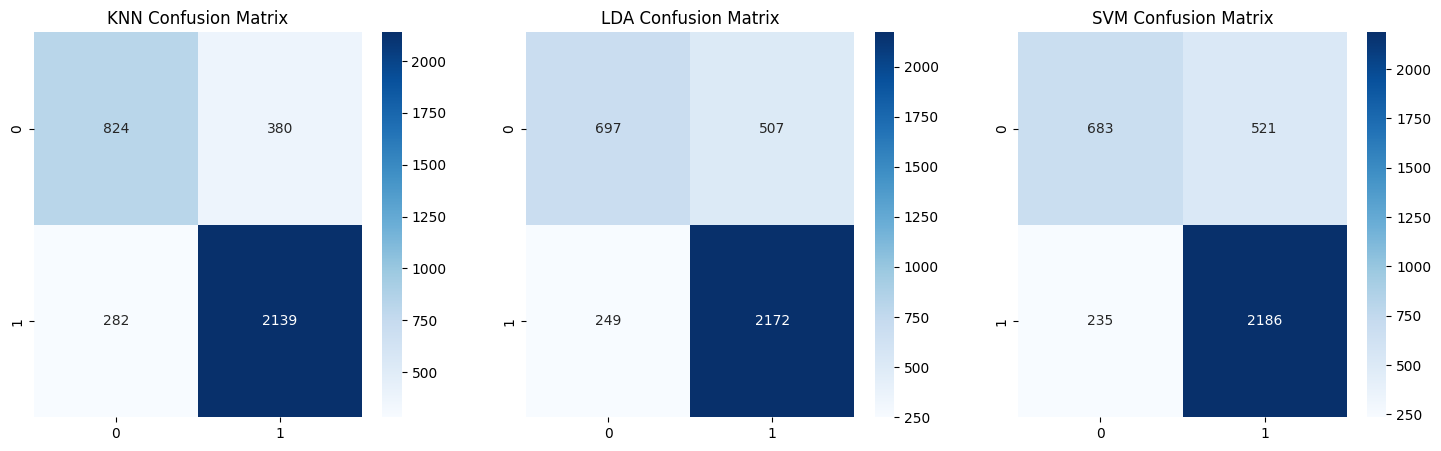

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions using the best KNN model
knn_pred = best_knn_model.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_pred)

# Predictions using the best LDA model
lda_pred = best_lda_model.predict(X_test)
lda_conf_matrix = confusion_matrix(y_test, lda_pred)

# Predictions using the best SVM model
svm_pred = best_svm_model.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KNN confusion matrix
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title('KNN Confusion Matrix')

# LDA confusion matrix
sns.heatmap(lda_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title('LDA Confusion Matrix')

# SVM confusion matrix
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')

plt.show()

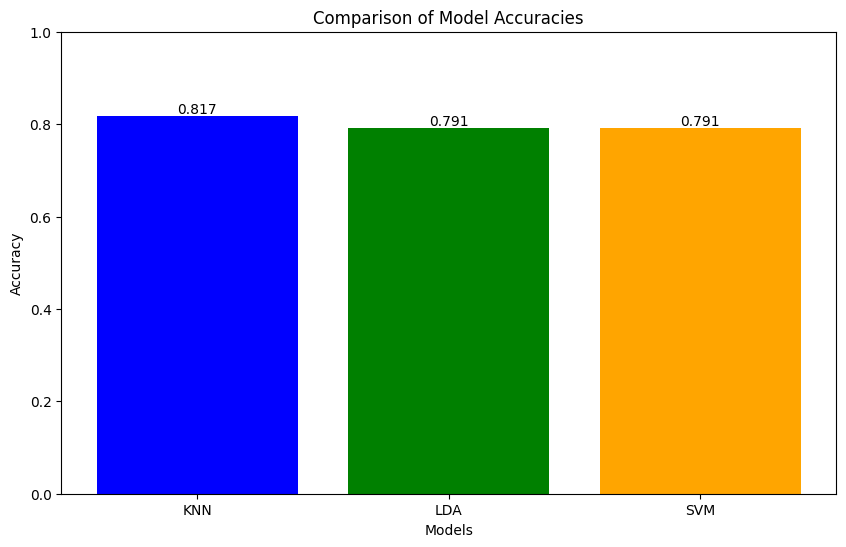

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculating model accuracies
accuracy_knn = accuracy_score(y_test, knn_pred)
accuracy_lda = accuracy_score(y_test, lda_pred)
accuracy_svm = accuracy_score(y_test, svm_pred)

accuracies = [accuracy_knn, accuracy_lda, accuracy_svm]
models = ['KNN', 'LDA', 'SVM']

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Displaying values above the bars
for index, value in enumerate(accuracies):
    plt.text(index, value, str(round(value, 3)), ha='center', va='bottom')

# Displaying the chart
plt.ylim(0, 1)
plt.show()